<a href="https://colab.research.google.com/github/Fernando23127/2022_Ingenieria/blob/main/TrabajoFinal_Au.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import sys
import os

In [4]:
if 'google.colab' in sys.modules:
    os.system('apt install python3-mpi4py cython3 libxc-dev gpaw-data')
    os.system('pip install --upgrade gpaw pymatgen')

In [5]:
from ase.build import bulk
from ase.atom import Atom
from ase.atoms import Atoms
from gpaw import GPAW, PW
from ase.visualize.plot import plot_atoms
from ase.visualize import view
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
plt.rc('figure', figsize=(18,6))
plt.rc('font', size=20)
from ase.eos import EquationOfState

Genero Estructura

In [6]:
AuFCC = bulk('Au', 'fcc', a=4., cubic=True)

In [7]:
calc = GPAW(mode=PW(300), xc='PBE', txt='AuFCC.txt',kpts=[5,5,5])
AuFCC.set_calculator(calc)
AuFCC.get_potential_energy()

-11.567181560509455

In [8]:
structures = [('fcc', AuFCC, 4.0)]

In [9]:
kpoints = [3, 4, 5,7,9,11,13]
Ekpt = {}

In [10]:
for case in structures:
    name, struc, latpar = case
    Ekpt[name] = np.array([])
    for kpt in tqdm(kpoints):
        calc = GPAW(mode=PW(300), txt=f'{name}_{kpt}.txt', xc='PBE',kpts=[kpt,kpt,kpt])
        struc.set_calculator(calc)
        Ekpt[name]=np.append(Ekpt[name], struc.get_potential_energy()/struc.get_global_number_of_atoms())

  0%|          | 0/7 [00:00<?, ?it/s]

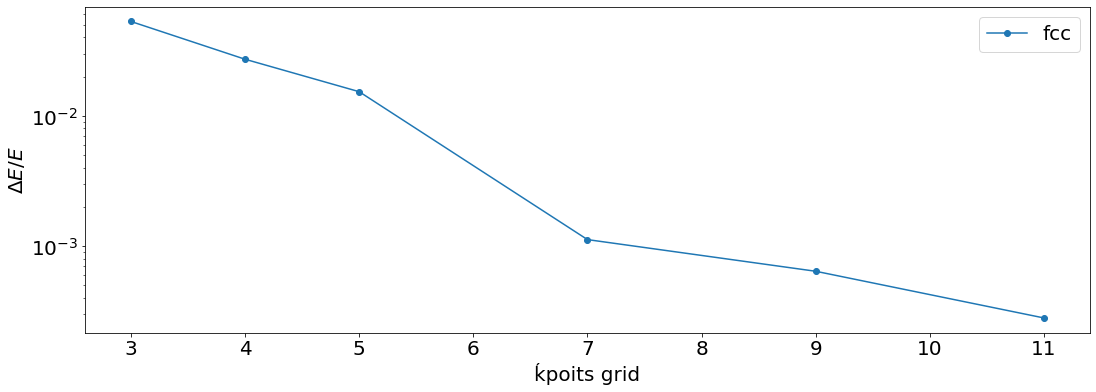

In [11]:
plots = [plt.plot(kpoints[:-1], np.abs((energies[:-1]-energies[-1])/energies[-1]), '-o', label = struc) for struc, energies in Ekpt.items()]
plt.yscale('log')
plt.ylabel('$\Delta E / E$')
plt.xlabel('ḱpoits grid')
plt.legend()

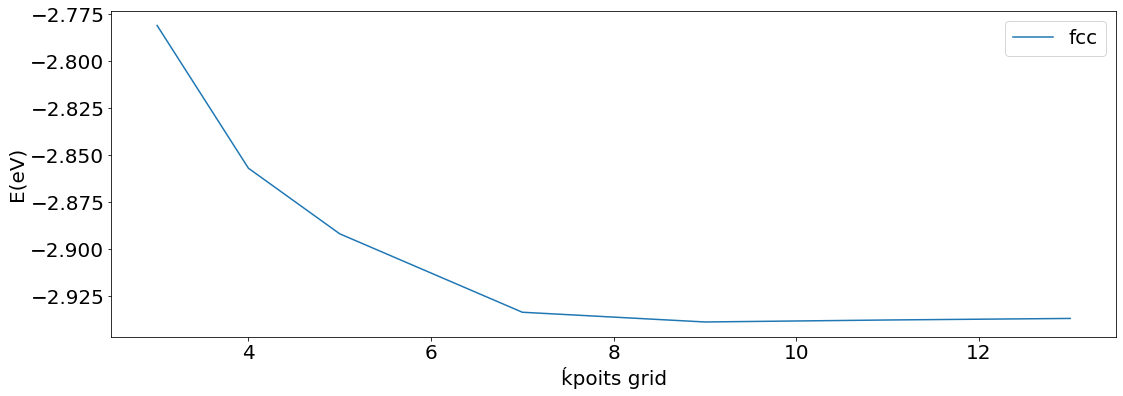

In [12]:
plots = [plt.plot(kpoints, energies, label = struc) for struc, energies in Ekpt.items()]
plt.ylabel('E(eV)')
plt.xlabel('ḱpoits grid')
plt.legend()

In [13]:
KPT= 10

Cuttoff Convergence

In [14]:
ecuts = [200, 250, 300, 400, 500,600]
Ecutoff = {}

In [15]:
structures

[('fcc',
  Atoms(symbols='Au4', pbc=True, cell=[4.0, 4.0, 4.0], calculator=GPAW(...)),
  4.0)]

In [16]:
for name, struc, latpar in structures:
#    structure = bulk('au', crystalstructure=struc, a=latpar, cubic=True)
    Ecutoff[name] = np.array([])
    for ecut in tqdm(ecuts):
        calc = GPAW(mode=PW(ecut), txt='out.txt', xc='PBE',kpts=[KPT,KPT,KPT])
        struc.set_calculator(calc)
        Ecutoff[name]=np.append(Ecutoff[name], struc.get_potential_energy()/struc.get_global_number_of_atoms())

  0%|          | 0/6 [00:00<?, ?it/s]

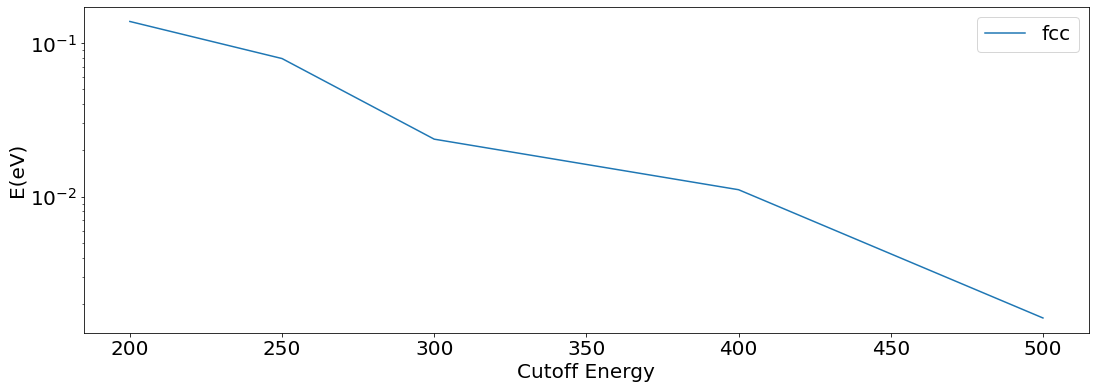

In [17]:
[plt.plot(ecuts[:-1], np.abs((energies[:-1]-energies[-1])/energies[-1]), label = name) for name, energies in Ecutoff.items()]
plt.yscale('log')
plt.ylabel('E(eV)')
plt.xlabel('Cutoff Energy')
plt.legend()

In [18]:
ECUT = 400

Lattice Parameter

In [19]:
latparams = {'fcc': np.linspace(3.8,4.5,10)}

In [20]:
def evcurve(element, structure, sizes, calculator):
    print(f'working on {element} in {structure}')
    structures = []
    E = []
    V = []
    progress = tqdm(sizes)
    for a in progress:
        calc = GPAW(mode=PW(ECUT), xc='PBE', txt=f'{element}{structure}_{a}.txt',kpts=[KPT,KPT,KPT])
        structures.append(bulk(element, structure, a=a, cubic=True))
        structures[-1].set_calculator(calculator)
        E.append(structures[-1].get_potential_energy())
        V.append(structures[-1].get_volume())
    return {'E': E, 'V': V, 'strucs': structures}

In [21]:
struc

Atoms(symbols='Au4', pbc=True, cell=[4.0, 4.0, 4.0], calculator=GPAW(...))

In [22]:
evcurves = {struc: evcurve('Au',struc, thissizes, calc) for struc, thissizes in latparams.items() }

working on Au in fcc


  0%|          | 0/10 [00:00<?, ?it/s]

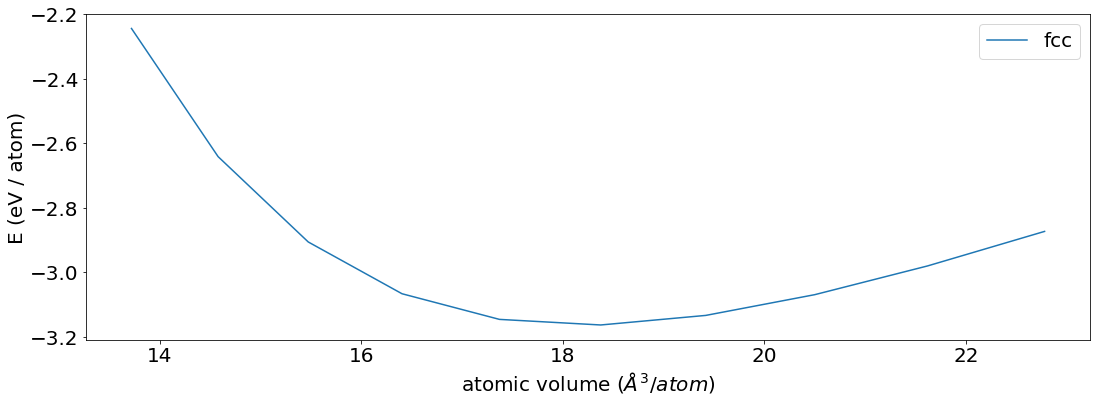

In [23]:
for struc, evcurve in evcurves.items():
    natoms = evcurve['strucs'][-1].get_global_number_of_atoms()
    plt.plot(np.array(evcurve['V'])/natoms,np.array(evcurve['E'])/natoms, label=struc)
plt.legend()
xlabel=plt.xlabel('atomic volume ($\AA ^3 / atom $)')
ylabel = plt.ylabel('E (eV / atom)')

Ecuacion de estado

In [24]:
eos = EquationOfState(evcurves['fcc']['V'],evcurves['fcc']['E'],eos='birchmurnaghan')

In [25]:
eos.fit()

(72.81283456446118, -12.656284846926313, 0.8587011728350968)

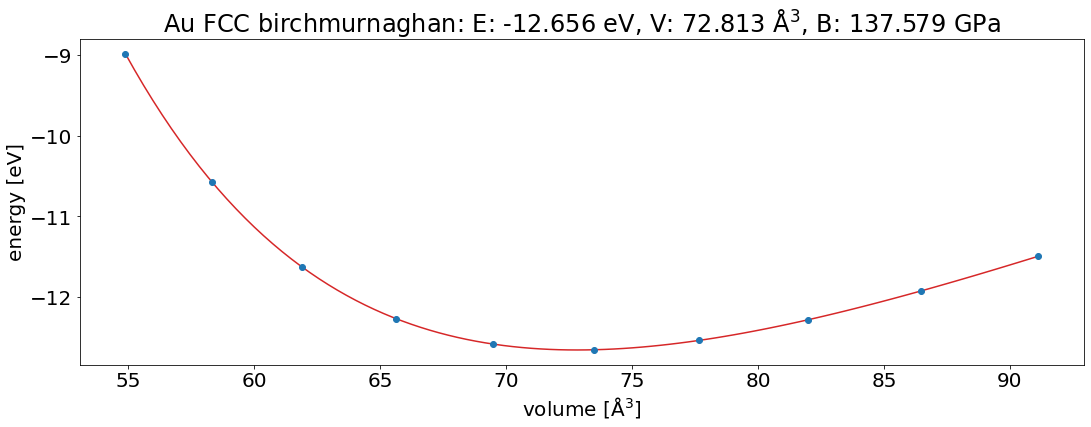

In [26]:
ax = eos.plot()
title = ax.get_title()
newtitle = ax.set_title('Au FCC ' + title)

In [27]:
eqa = eos.v0**(1/3)

In [28]:
eqa

4.17576432279476

Muy parecido a los resultados publicados en este trabajo de NOMAD: https://nomad-lab.eu/prod/v1/gui/search/entries/entry/id/YDXZgPooRb-31Niq48ODPA/SoO62gAV0cVK9WRCD5M-8Xh_T4OV

Generación de superficie n capas

In [29]:
from ase.build import surface, fcc100, fcc110, fcc111, make_supercell

In [30]:
AuMonoLayer = fcc100('Au',[1,1,1], a=eqa, vacuum=10)

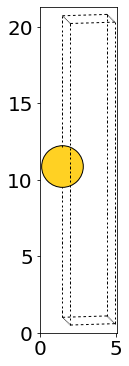

In [31]:
plot_atoms(AuMonoLayer, rotation='90x, 10y, 10x')

Agregó capas con la direccion [110] mas compacta en la FCC

In [32]:
AuMonoLayer1 = fcc110('Au',[1,1,1], a=eqa, vacuum=10)

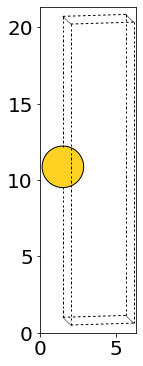

In [33]:
plot_atoms(AuMonoLayer1, rotation='90x, 10y, 10x')

con lo cual construimos una n-capa de oro fcc con índices de miller 100. para poder visualizar esta bicapa con mas repeticiones, podemos repetir mas veces la supercelda que acabamos de crear,

In [34]:
AuMonoLayer_2x2 = make_supercell(AuMonoLayer, [[2,0,0],[0,2,0],[0,0,1]])
AuMonoLayer_3x3 = make_supercell(AuMonoLayer, [[3,0,0],[0,3,0],[0,0,1]])
AuMonoLayer_4x4 = make_supercell(AuMonoLayer, [[4,0,0],[0,4,0],[0,0,1]])

In [35]:
AuMonoLayer1_2x2 = make_supercell(AuMonoLayer1, [[2,0,0],[0,2,0],[0,0,1]])
AuMonoLayer1_3x3 = make_supercell(AuMonoLayer1, [[3,0,0],[0,3,0],[0,0,1]])
AuMonoLayer1_4x4 = make_supercell(AuMonoLayer1, [[4,0,0],[0,4,0],[0,0,1]])

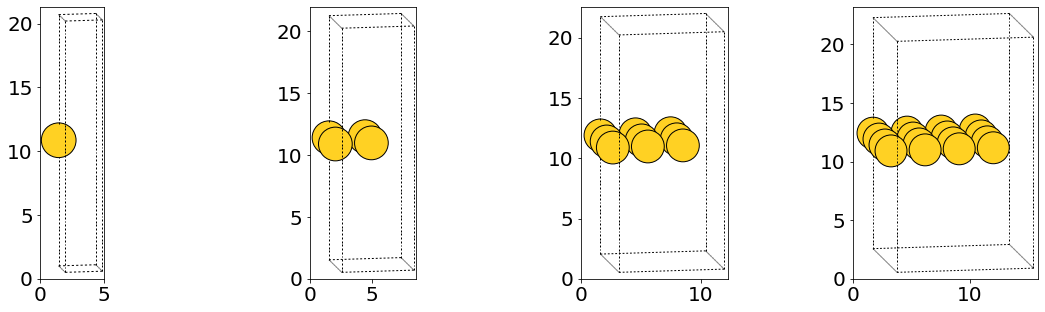

In [36]:
fig, ax = plt.subplots(1,4,figsize=(20,5))
plot_atoms(AuMonoLayer, rotation='90x, 10y, 10x', ax=ax[0])
plot_atoms(AuMonoLayer_2x2, rotation='90x, 10y, 10x', ax=ax[1])
plot_atoms(AuMonoLayer_3x3, rotation='90x, 10y, 10x', ax=ax[2])
plot_atoms(AuMonoLayer_4x4, rotation='90x, 10y, 10x', ax=ax[3])

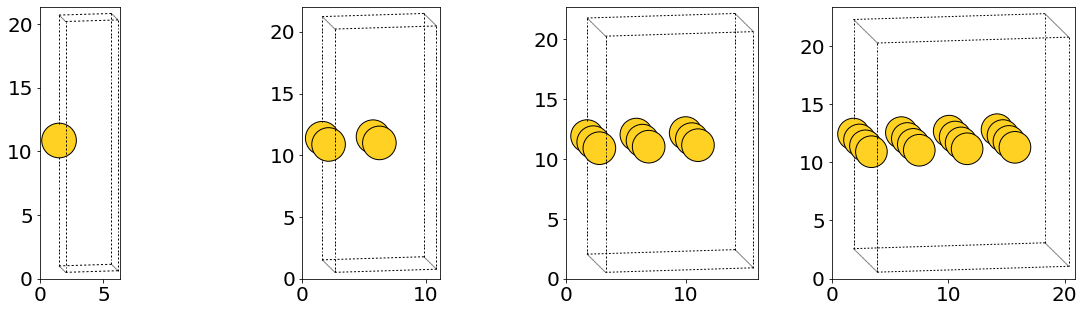

In [37]:
fig, ax = plt.subplots(1,4,figsize=(20,5))
plot_atoms(AuMonoLayer1, rotation='90x, 10y, 10x', ax=ax[0])
plot_atoms(AuMonoLayer1_2x2, rotation='90x, 10y, 10x', ax=ax[1])
plot_atoms(AuMonoLayer1_3x3, rotation='90x, 10y, 10x', ax=ax[2])
plot_atoms(AuMonoLayer1_4x4, rotation='90x, 10y, 10x', ax=ax[3])

Calculos de superficies

In [38]:
en_pot100= []
en_pot110= []

Monocapa de Au / 1° [100]; 2° [110]

In [39]:
calc = GPAW(mode=PW(ECUT), txt='AuMonolayer.txt', xc='PBE', kpts=[KPT, KPT, 1])
AuMonoLayer.set_calculator(calc)
en_pot100.append(AuMonoLayer.get_potential_energy())
AuMonoLayer1.set_calculator(calc)
en_pot110.append(AuMonoLayer1.get_potential_energy())

Bicapa de Au / 1° [100]; 2° [110]

In [40]:
calc = GPAW(mode=PW(ECUT), txt='AuMonolayer_2x2.txt', xc='PBE', kpts=[KPT/2, KPT/2, 1])
AuMonoLayer_2x2.set_calculator(calc)
en_pot100.append(AuMonoLayer_2x2.get_potential_energy())
AuMonoLayer1_2x2.set_calculator(calc)
en_pot110.append(AuMonoLayer1_2x2.get_potential_energy())

Tricapa de Au / 1° [100]; 2° [110]

In [41]:
calc = GPAW(mode=PW(ECUT), txt='AuMonolayer_3x3.txt', xc='PBE', kpts=[KPT/3, KPT/3, 1])
AuMonoLayer_3x3.set_calculator(calc)
en_pot100.append(AuMonoLayer_3x3.get_potential_energy())
AuMonoLayer1_3x3.set_calculator(calc)
en_pot110.append(AuMonoLayer1_3x3.get_potential_energy())

Tetracapa de Au / 1° [100]; 2° [110]

In [42]:
calc = GPAW(mode=PW(ECUT), txt='AuMonolayer_4x4.txt', xc='PBE', kpts=[KPT/4, KPT/4, 1])
AuMonoLayer_4x4.set_calculator(calc)
en_pot100.append(AuMonoLayer_4x4.get_potential_energy())
AuMonoLayer1_4x4.set_calculator(calc)
en_pot110.append(AuMonoLayer1_4x4.get_potential_energy())

Densidad de estados (DOS)

In [43]:
AuFCC = bulk('Au', 'fcc', a=eqa)

In [44]:
#Tardó alrededor de 1h 30min
calc = GPAW(mode=PW(ECUT), xc='PBE', kpts=[15,15,15], txt='equilibrium.txt')
AuFCC.set_calculator(calc)
AuFCC.get_potential_energy()
calcML = GPAW(mode=PW(ECUT), xc='PBE', kpts=[15,15,1], txt='equilibrium.txt')
calcBL = GPAW(mode=PW(ECUT), xc='PBE', kpts=[15/2,15/2,1], txt='equilibrium.txt')
calcTriL = GPAW(mode=PW(ECUT), xc='PBE', kpts=[15/3,15/3,1], txt='equilibrium.txt')
calcTetraL = GPAW(mode=PW(ECUT), xc='PBE', kpts=[15/4,15/4,1], txt='equilibrium.txt')
#Monocapa [100]
AuMonoLayer.set_calculator(calcML)
AuMonoLayer.get_potential_energy()
#Bicapa [100]
AuMonoLayer_2x2.set_calculator(calcBL)
AuMonoLayer_2x2.get_potential_energy()
#Tricapa [100]
AuMonoLayer_3x3.set_calculator(calcTriL)
AuMonoLayer_3x3.get_potential_energy()
#Tetra capa [100]
AuMonoLayer_4x4.set_calculator(calcTetraL)
AuMonoLayer_4x4.get_potential_energy()
#Monocapa [110]
AuMonoLayer1.set_calculator(calcML)
AuMonoLayer1.get_potential_energy()
#Bicapa [110]
AuMonoLayer1_2x2.set_calculator(calcBL)
AuMonoLayer1_2x2.get_potential_energy()
#Tricapa [110]
AuMonoLayer1_3x3.set_calculator(calcTriL)
AuMonoLayer1_3x3.get_potential_energy()
#Tetra capa [110]
AuMonoLayer1_4x4.set_calculator(calcTetraL)
AuMonoLayer1_4x4.get_potential_energy()



-23.717431507269694

Calculo las energias y el DOS de las capas con los indices [100]

In [45]:
e,dos = AuFCC.calc.get_dos(npts=500)
e2_100, dos_ml_100 = AuMonoLayer.calc.get_dos(npts=500)
e3_100, dos_bl_100 = AuMonoLayer_2x2.calc.get_dos(npts=500)
e4_100, dos_tril_100 = AuMonoLayer_3x3.calc.get_dos(npts=500)
e5_100, dos_tetral_100 = AuMonoLayer_4x4.calc.get_dos(npts=500)
ef = AuFCC.calc.get_fermi_level()
efml_100 = AuMonoLayer.calc.get_fermi_level()
efbl_100 = AuMonoLayer_2x2.calc.get_fermi_level()
eftril_100 = AuMonoLayer_3x3.calc.get_fermi_level()
eftetral_100 = AuMonoLayer_4x4.calc.get_fermi_level()

Calculo las energias y el DOS de las capas con los indices [110]:

In [46]:
e2_110, dos_ml_110 = AuMonoLayer1.calc.get_dos(npts=500)
e3_110, dos_bl_110 = AuMonoLayer1_2x2.calc.get_dos(npts=500)
e4_110, dos_tril_110 = AuMonoLayer1_3x3.calc.get_dos(npts=500)
e5_110, dos_tetral_110 = AuMonoLayer1_4x4.calc.get_dos(npts=500)
efml_110 = AuMonoLayer1.calc.get_fermi_level()
efbl_110 = AuMonoLayer1_2x2.calc.get_fermi_level()
eftril_110 = AuMonoLayer1_3x3.calc.get_fermi_level()
eftetral_110 = AuMonoLayer1_4x4.calc.get_fermi_level()

Gráfico para las capas con indices [100]

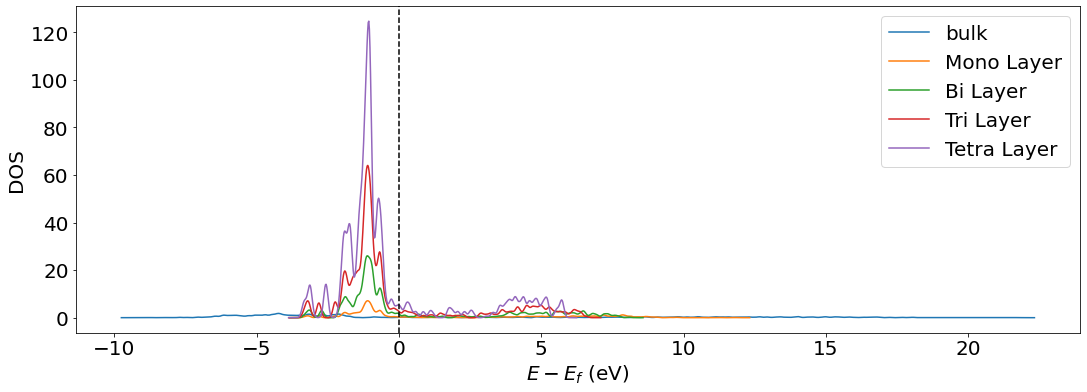

In [47]:
plt.plot(e-ef,dos, label='bulk')
plt.plot(e2_100-efml_100,dos_ml_100, label='Mono Layer')
plt.plot(e3_100-efbl_100,dos_bl_100, label='Bi Layer')
plt.plot(e4_100-eftril_100,dos_tril_100, label='Tri Layer')
plt.plot(e5_100-eftetral_100,dos_tetral_100, label='Tetra Layer')
plt.axvline(color='k', linestyle='--')
plt.xlabel('$E - E_f$ (eV)')
plt.ylabel('DOS')
plt.legend()

Grafico para las capas con indices [110]

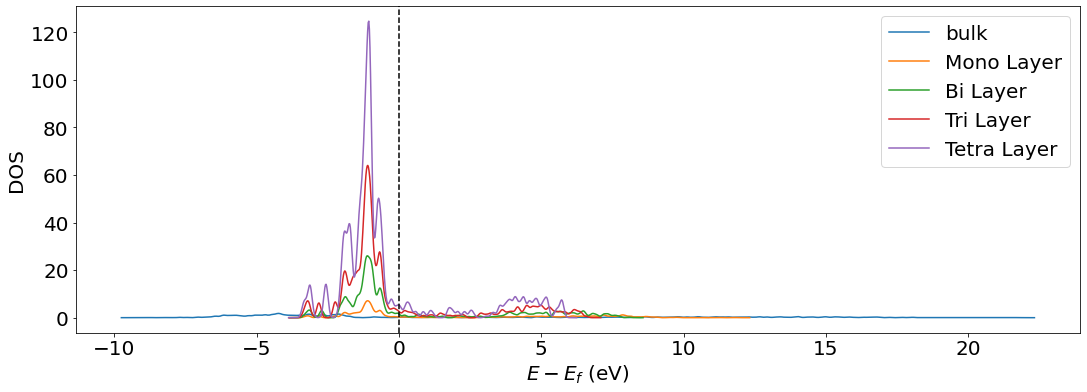

In [48]:
plt.plot(e-ef,dos, label='bulk')
plt.plot(e2_110-efml_110,dos_ml_110, label='Mono Layer')
plt.plot(e3_110-efbl_110,dos_bl_110, label='Bi Layer')
plt.plot(e4_110-eftril_110,dos_tril_110, label='Tri Layer')
plt.plot(e5_110-eftetral_110,dos_tetral_110, label='Tetra Layer')
plt.axvline(color='k', linestyle='--')
plt.xlabel('$E - E_f$ (eV)')
plt.ylabel('DOS')
plt.legend()